### imports

In [1]:
import matplotlib.pyplot as plt
import config
# import visualkeras
import keras
import sklearn
import tensorflow as tf
import os
import cv2
import numpy as np
from math import ceil
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from segmentation_models.metrics import iou_score, IOUScore, FScore
# TF CONFIGURATION
print("Número de GPUs disponíveis: ", len(
    tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU') #força usar a 0
        tf.config.experimental.set_memory_growth(gpus[0], True) #so usa memoria a medida q precisa
    except RuntimeError as e:
        print(e)

2024-02-24 15:17:07.960202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 15:17:08.071997: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 15:17:08.531298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-24 15:17:08.531344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Segmentation Models: using `keras` framework.
Número de GPUs disponíveis:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2024-02-24 15:17:09.318287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:09.318725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:09.325057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:09.325509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:09.326155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [2]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
from keras.models import load_model

### configs

In [3]:
#TRAIN - caminho das pastas
train_images_path = "Dataset/train/Images_Cropped"
train_masks_path = "Dataset/train/Masks_Cropped"
#VAL
val_images_path = "Dataset/val/Images_Cropped"
val_masks_path = "Dataset/val/Masks_Cropped"
#TEST
test_images_path = "Dataset/test/Images_Cropped"
test_masks_path = "Dataset/test/Masks_Cropped"

#TRAIN - lista com todos os nomes dos arquivos de imagem
train_images_list = os.listdir(train_images_path)
train_masks_list = os.listdir(train_masks_path)
#VAL
val_images_list = os.listdir(val_images_path)
val_masks_list = os.listdir(val_masks_path)
#TEST
test_images_list = os.listdir(test_images_path)
test_masks_list = os.listdir(test_masks_path)

#TRAIN - ordenação dos nomes dos arquivos
train_images_list.sort()
train_masks_list.sort()
#VAL
val_images_list.sort()
val_masks_list.sort()
#VAL
test_images_list.sort()
test_masks_list.sort()

In [5]:
len(train_images_list)

400

In [4]:
def image_mask_generator(images_list, images_path, masks_path, batch_size= config.BATCH_SIZE, output_size=config.IMAGE_SIZE):
    num_samples = len(images_list)
    while True:
        # Embaralhar os índices para garantir que os dados sejam apresentados de forma aleatória
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            
            batch_masks = []
            for idx in batch_indices:
                img_filename = os.path.join(images_path, images_list[idx])
                mask_filename = os.path.join(masks_path, images_list[idx][:-4] + ".png")

                if not os.path.isfile(img_filename) or not os.path.isfile(mask_filename):
                    print(f"Arquivo de imagem ou máscara não encontrado: {images_list[idx]}")
                    continue

                img = cv2.imread(img_filename)
                mask = cv2.imread(mask_filename, cv2.IMREAD_UNCHANGED) #cv2.IMREAD_GRAYSCALE
                
                if img is None or mask is None:
                    print(f"Falha ao carregar imagem ou máscara: {images_list[idx]}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, output_size)
                mask = cv2.resize(mask, output_size, interpolation=cv2.INTER_NEAREST)
                
                img = img.astype(np.float32) / 255.0
                mask = tf.one_hot(mask, 3)

                batch_images.append(img)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

### gerador

In [5]:
gerador_treino = image_mask_generator(train_images_list, train_images_path, train_masks_path)

In [6]:
gerador_validacao = image_mask_generator(val_images_list, val_images_path, val_masks_path)

In [5]:
gerador_teste = image_mask_generator(test_images_list, test_images_path, test_masks_path)

### plot batch

In [10]:
def exibir_mascaras_em_batch(gerador):
    """
    Plota a Imagem Original e a Máscara de Segmentação lado a lado.

    Args:
        gerador (generator): Gerador que retorna tuplas contendo (imagem, mascara).
    Returns:
        None: Sem retorno.
    """
    imagens_mostradas = 0  # Contador para controlar o número de imagens mostradas
    for batch_imagens, batch_mascaras in gerador:
        for imagem, mascara in zip(batch_imagens, batch_mascaras):
            if imagens_mostradas >= 4:
                return  # Sai da função se já foram mostradas 4 imagens
            overlay = np.copy(imagem)
            overlay[mascara == 2] = 255  # Valor para a classe 2_cup(transparência reduzida)
            overlay[mascara == 1] = 128  # Valor para a classe 1_disco (transparência aumentada)
            
            fig, axes = plt.subplots(1, 3, figsize=(8, 4))
            axes[0].imshow(imagem, cmap='gray')
            axes[0].set_title('Imagem')
            axes[1].imshow(mascara, cmap='viridis', vmin=0, vmax=2)  # 'viridis' para destacar classes.
            axes[1].set_title('Máscara')
            axes[2].imshow(overlay, cmap='viridis')
            axes[2].set_title('Sobreposição')
            plt.tight_layout()

            plt.show()
            imagens_mostradas += 1



2024-02-23 15:32:24.001515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 15:32:24.001883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-23 15:32:24.002628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-23 15:32:24.003192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

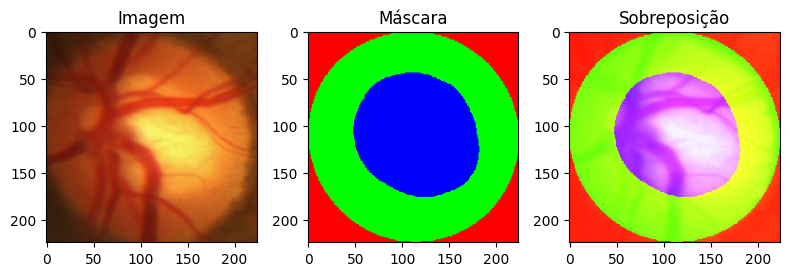

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


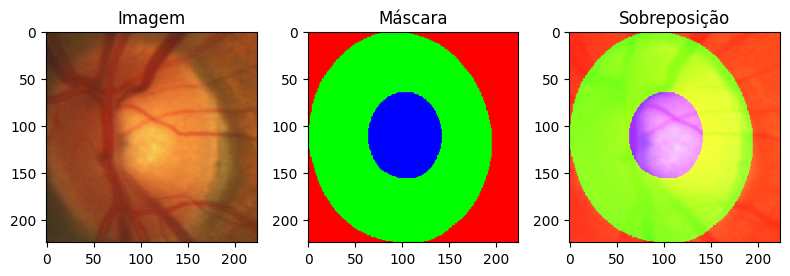

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


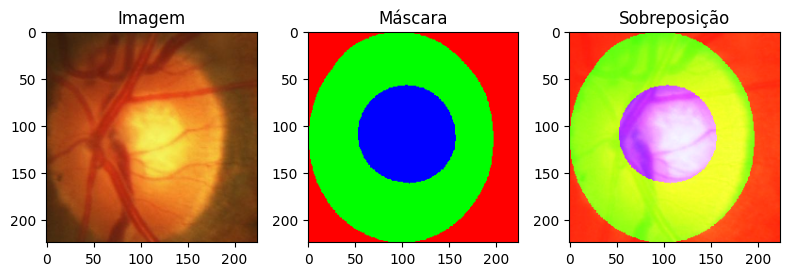

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


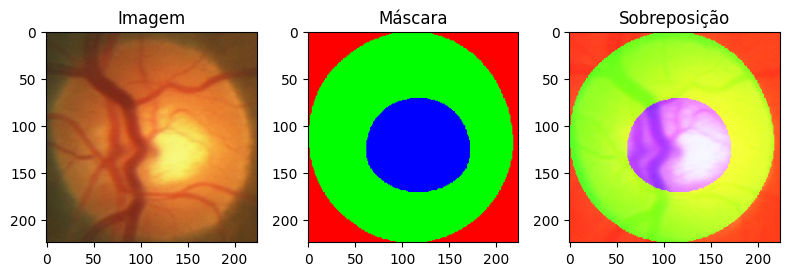

In [11]:
# Chamar a função com o gerador
exibir_mascaras_em_batch(gerador_treino)


### fit and model

In [12]:
# # Define a função de métrica IoU personalizada
# def iou_metric(y_true, y_pred):
#     return iou_score(y_true, y_pred)

In [6]:
model = Unet(input_shape= (224,224,3), classes=3, backbone_name='efficientnetb1', encoder_weights='imagenet', encoder_freeze=True, activation='softmax')
# Compile o modelo usando a função de perda e métrica corretas
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= config.LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics= [IOUScore(class_indexes=1, threshold=0.5, name='iou_disco'), IOUScore(class_indexes=2, threshold=0.5, name='iou_cup'), FScore(class_indexes=1, threshold=0.5, name='dice_disco'), FScore(class_indexes=2, threshold=0.5, name='dice_cup')  ])

2024-02-24 15:17:20.844149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 15:17:20.844622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:20.845074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-24 15:17:20.845443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                             

In [15]:
dot_img_file = '/modelo.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
model.output.shape

TensorShape([None, 224, 224, 3])

In [ ]:
# pretrain model decoder
callbacks_list = [EarlyStopping(monitor = 'val_iou_cup', patience = 5, mode = 'auto', verbose = 1),
                ModelCheckpoint("/home/arthur_guilherme/pibic_mack-24/checkpoint/best_model_weights.h5", monitor = 'val_iou_cup', verbose = 1, save_best_only = True, mode= 'max')]
model.fit(gerador_treino,
           validation_data = gerador_validacao,
           epochs= config.EPOCHS,
           callbacks = callbacks_list,
           steps_per_epoch= ceil(len(train_images_list)/config.BATCH_SIZE),
           validation_steps= ceil(len(val_images_list)/config.BATCH_SIZE),
           )


### PREDICT E TEST

In [ ]:
# #TODO dice score, ok
# test generator, ok
# predictions, 
# corrigir loss, ok
# verificar normalização das mascaras.ok

In [7]:
model.load_weights("/home/arthur_guilherme/pibic_mack-24/weights/train_UneBackEffB1_epoc54_val_iou_cup_74.h5")

In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [9]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [10]:
def show_predictions(generator, num=1):
    for i in range(num):
        image, mask = next(generator)
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])


2024-02-24 15:17:51.431006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2024-02-24 15:17:51.806279: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


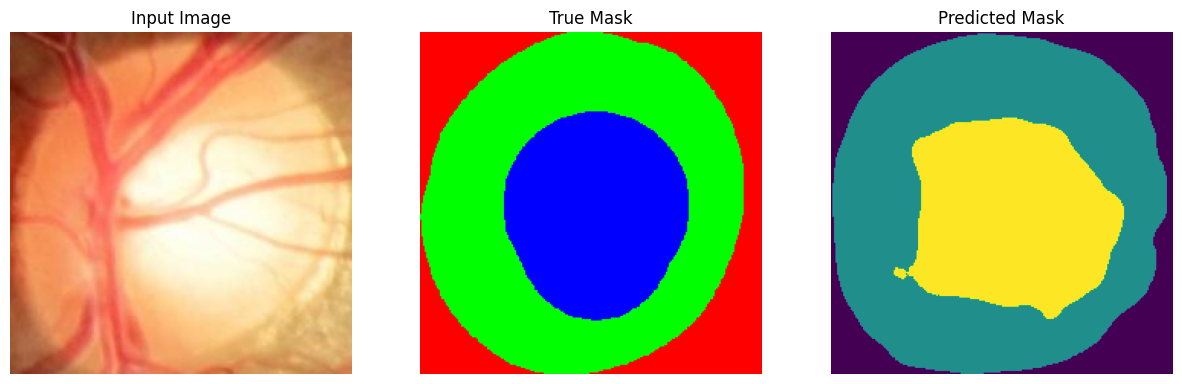

1/1 [==============================] - 0s 29ms/step


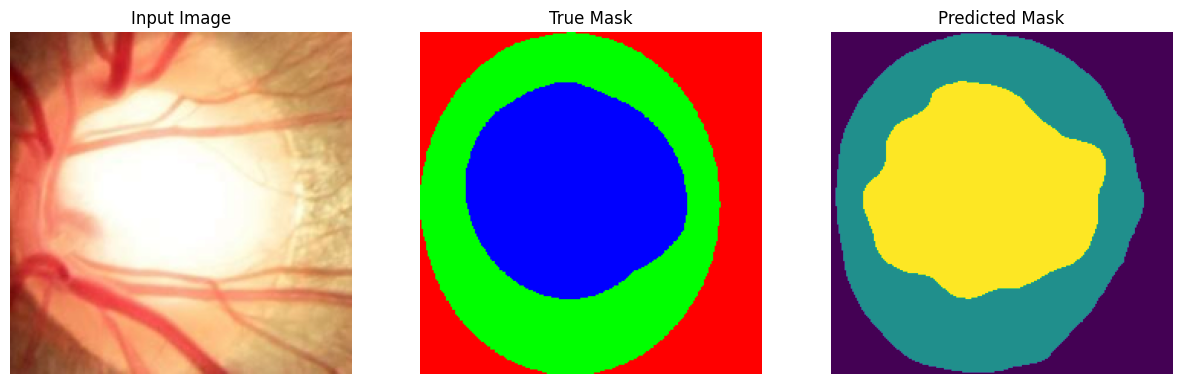

1/1 [==============================] - 0s 28ms/step


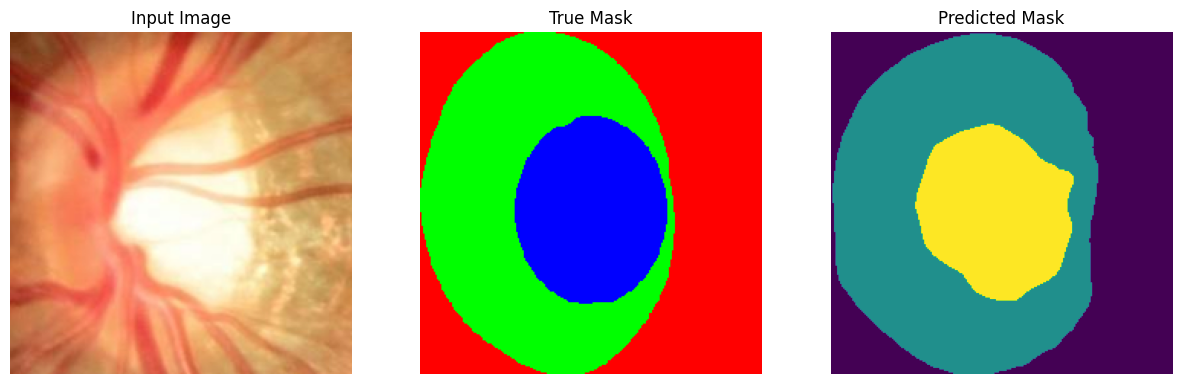

1/1 [==============================] - 0s 28ms/step


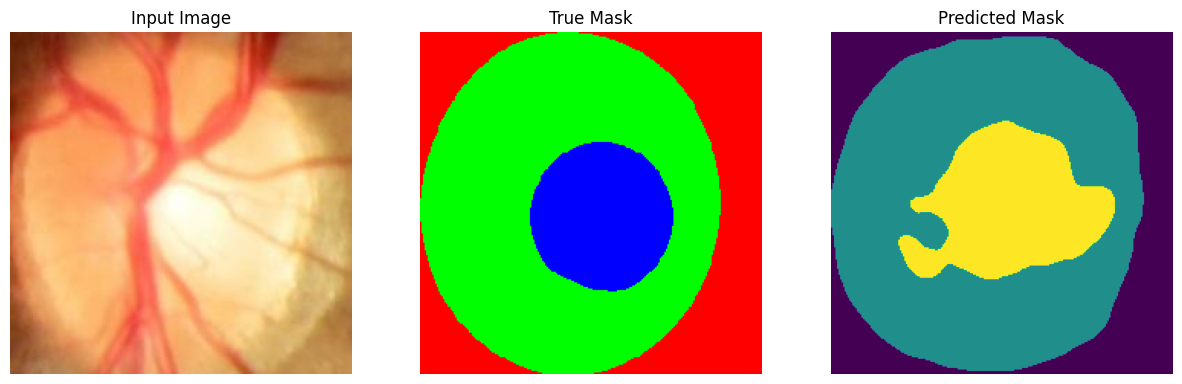

1/1 [==============================] - 0s 28ms/step


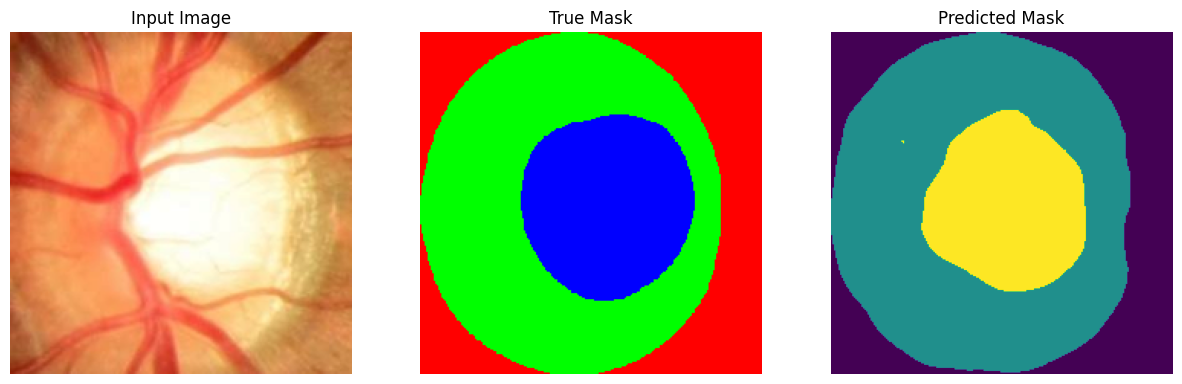

1/1 [==============================] - 0s 29ms/step


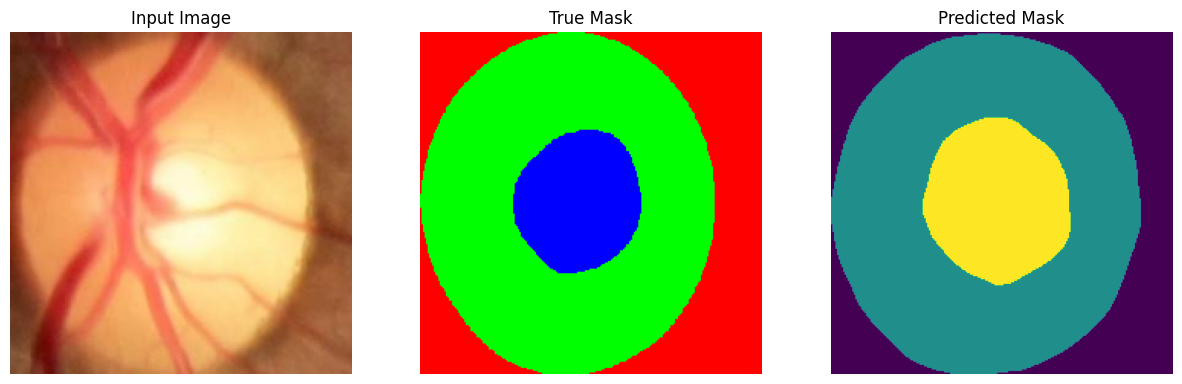

In [11]:
show_predictions(gerador_teste, 6)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(config.EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# Salvando o histórico do treinamento
import pickle

history = model.fit(
    gerador_treino,
    validation_data=gerador_validacao,
    epochs=config.EPOCHS,
    callbacks=callbacks_list,
    steps_per_epoch=ceil(len(train_images_list) / config.BATCH_SIZE),
    validation_steps=ceil(len(val_images_list) / config.BATCH_SIZE),
)


with open('history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
import pickle

# Carregando o histórico do treinamento
with open('history.pickle', 'rb') as file_pi:
    history = pickle.load(file_pi)

# Acesso às métricas de perda
loss = history['loss']
val_loss = history['val_loss']
